# Fashion Image Generator - Interactive Demo

## AMD GPU Compatible Version

This notebook provides an interactive interface to generate fashion images using your trained LoRA model.

### Features:
- 🎨 Single image generation
- 📦 Batch generation (by category)
- 🎯 Custom batch generation
- 🔀 Random sample exploration
- ✨ Beautiful UI with Jupyter widgets

---


In [19]:
# CELL 1: Environment Check (AMD GPU Compatible)
import os
import torch

print("🔧 Environment Check")
print("=" * 60)
print(f"PyTorch Version: {torch.__version__}")
print(f"GPU Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU Count: {torch.cuda.device_count()}")
    print(f"GPU 0: {torch.cuda.get_device_name(0)}")
    device = torch.device("cuda")
else:
    print("⚠️ No GPU detected, using CPU (slower)")
    device = torch.device("cpu")

print("=" * 60)

# Verify required packages
try:
    import cv2
    import numpy as np
    from PIL import Image
    import matplotlib.pyplot as plt
    from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
    print("✅ All required dependencies available")
except ImportError as e:
    print(f"❌ Missing dependency: {e}")
    print("Run: pip install -r requirements.txt")

print("\n💡 Ready to launch Fashion Image Generator!")

🔧 Environment Check
PyTorch Version: 2.5.1+rocm6.2
GPU Available: True
GPU Count: 8
GPU 0: AMD Instinct MI250X/MI250
✅ All required dependencies available

💡 Ready to launch Fashion Image Generator!


In [20]:
# CELL 2: Load Model (AMD GPU Compatible)
import torch
import cv2
import numpy as np
from PIL import Image
import os
import glob
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler

print("=" * 60)
print("🔍 LOADING FASHION SYNTHESIS MODEL")
print("=" * 60)

# --- 1. Configure Paths (Local Setup) ---
WORKING_DIR = "/home/husnain/DLP/working"
LORA_WEIGHTS_PATH = os.path.join(WORKING_DIR, "fashion_lora_output")
SAMPLE_IMAGES_DIR = os.path.join(WORKING_DIR, "eval_data/gt")

# Verify paths exist
print("\n📂 Checking paths...")
if not os.path.exists(LORA_WEIGHTS_PATH):
    raise FileNotFoundError(f"❌ LoRA weights directory not found: {LORA_WEIGHTS_PATH}")

weights_file = os.path.join(LORA_WEIGHTS_PATH, "pytorch_lora_weights.safetensors")
if not os.path.exists(weights_file):
    raise FileNotFoundError(f"❌ LoRA weights file not found: {weights_file}")

print(f"✅ Found LoRA weights at: {LORA_WEIGHTS_PATH}")

# --- 2. Load Sample Images ---
sample_image_paths = {}
if os.path.exists(SAMPLE_IMAGES_DIR):
    image_files = sorted(glob.glob(os.path.join(SAMPLE_IMAGES_DIR, "*.png")))[:1000]
    for i, img_path in enumerate(image_files):
        sample_image_paths[f"Sample {i+1:04d}"] = img_path
    print(f"✅ Loaded {len(sample_image_paths)} sample images from: {SAMPLE_IMAGES_DIR}")
else:
    print(f"⚠️ Sample images directory not found: {SAMPLE_IMAGES_DIR}")
    print("   You can still upload your own images!")

# --- 3. Device Configuration ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🎮 Using device: {device}")

# AMD GPUs work best with FP16
use_fp16 = torch.cuda.is_available()
dtype = torch.float16 if use_fp16 else torch.float32
print(f"📊 Precision: {'FP16 (mixed precision)' if use_fp16 else 'FP32 (full precision)'}")

# --- 4. Load Pipeline ---
print("\n⚙️ Loading ControlNet...")
controlnet = ControlNetModel.from_pretrained(
    "lllyasviel/control_v11p_sd15_canny",
    torch_dtype=dtype,
    cache_dir=os.path.join(WORKING_DIR, "model_cache")
)

print("⚙️ Loading Stable Diffusion Pipeline...")
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    controlnet=controlnet,
    torch_dtype=dtype,
    safety_checker=None,
    cache_dir=os.path.join(WORKING_DIR, "model_cache")
).to(device)

# Use efficient scheduler
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# Enable memory optimizations for AMD GPUs
if hasattr(pipe, 'enable_attention_slicing'):
    pipe.enable_attention_slicing()
    print("✅ Attention slicing enabled (memory efficient)")

# Try to enable XFormers if available (works on AMD with ROCm 5.7+)
try:
    pipe.enable_xformers_memory_efficient_attention()
    print("✅ XFormers memory efficient attention enabled")
except Exception:
    print("⚪ XFormers not available (optional optimization)")

print("\n⚙️ Loading LoRA Weights...")
pipe.load_lora_weights(LORA_WEIGHTS_PATH, weight_name="pytorch_lora_weights.safetensors")

print("\n" + "=" * 60)
print("✅ MODEL LOADED SUCCESSFULLY!")
print("=" * 60)
print(f"Device: {device}")
print(f"LoRA Weights: {weights_file}")
print(f"Sample Images: {len(sample_image_paths)}")
print("=" * 60)

🔍 LOADING FASHION SYNTHESIS MODEL

📂 Checking paths...
✅ Found LoRA weights at: /home/husnain/DLP/working/fashion_lora_output
✅ Loaded 1000 sample images from: /home/husnain/DLP/working/eval_data/gt

🎮 Using device: cuda
📊 Precision: FP16 (mixed precision)

⚙️ Loading ControlNet...


⚙️ Loading Stable Diffusion Pipeline...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

You have disabled the safety checker for <class 'diffusers.pipelines.controlnet.pipeline_controlnet.StableDiffusionControlNetPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


✅ Attention slicing enabled (memory efficient)
⚪ XFormers not available (optional optimization)

⚙️ Loading LoRA Weights...

✅ MODEL LOADED SUCCESSFULLY!
Device: cuda
LoRA Weights: /home/husnain/DLP/working/fashion_lora_output/pytorch_lora_weights.safetensors
Sample Images: 1000


In [21]:
# CELL 3: Helper Functions
import random
import os
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import hashlib

def get_lora_weights_info():
    """Get LoRA weights information for reproducibility."""
    try:
        # Try to get LORA_WEIGHTS_PATH from global scope, or use default
        if 'LORA_WEIGHTS_PATH' in globals():
            lora_path = LORA_WEIGHTS_PATH
        else:
            # Default path if not defined
            working_dir = "/home/husnain/DLP/working"
            lora_path = os.path.join(working_dir, "fashion_lora_output")
        
        weights_file = os.path.join(lora_path, "pytorch_lora_weights.safetensors")
        if os.path.exists(weights_file):
            # Calculate file hash for reproducibility
            sha256_hash = hashlib.sha256()
            with open(weights_file, "rb") as f:
                # Read file in chunks to handle large files
                for byte_block in iter(lambda: f.read(4096), b""):
                    sha256_hash.update(byte_block)
            file_hash = sha256_hash.hexdigest()[:16]  # First 16 chars for brevity
            
            # Get file size and modification time
            file_size = os.path.getsize(weights_file)
            mod_time = os.path.getmtime(weights_file)
            
            return {
                "path": weights_file,
                "hash": file_hash,
                "size": file_size,
                "mod_time": mod_time
            }
        else:
            return {"path": "Not found", "hash": "N/A"}
    except Exception as e:
        return {"path": f"Error: {str(e)}", "hash": "N/A"}

def save_generation_results(source_img, generated_img, seed, prompt, steps=20, guidance=7.5, prefix="output"):
    """Save source image, generated image, LoRA weights copy, and metadata for reproducibility."""
    import json
    import shutil
    from datetime import datetime
    
    # Get LoRA weights info
    lora_info = get_lora_weights_info()
    
    # Create base filename with seed
    base_filename = f"{prefix}_seed{seed}"
    
    # Save source image
    source_filename = f"{base_filename}_source.png"
    source_img.save(source_filename)
    
    # Save generated image
    generated_filename = f"{base_filename}_generated.png"
    generated_img.save(generated_filename)
    
    # Copy LoRA weights file for reproducibility
    lora_weights_filename = None
    original_weights_path = lora_info.get("path", "")
    if original_weights_path and os.path.exists(original_weights_path):
        lora_weights_filename = f"{base_filename}_lora_weights.safetensors"
        try:
            shutil.copy2(original_weights_path, lora_weights_filename)
        except Exception as e:
            print(f"⚠️  Warning: Could not copy LoRA weights file: {e}")
            lora_weights_filename = None
    
    # Create metadata dictionary
    metadata = {
        "seed": seed,
        "prompt": prompt,
        "steps": steps,
        "guidance_scale": guidance,
        "lora_weights": {
            "original_path": lora_info.get("path", "N/A"),
            "hash": lora_info.get("hash", "N/A"),
            "size_bytes": lora_info.get("size", 0),
            "modification_time": lora_info.get("mod_time", 0),
            "saved_copy": lora_weights_filename if lora_weights_filename else "N/A"
        },
        "files": {
            "source_image": source_filename,
            "generated_image": generated_filename,
            "lora_weights": lora_weights_filename if lora_weights_filename else "N/A"
        },
        "timestamp": datetime.now().isoformat()
    }
    
    # Save metadata as JSON
    metadata_filename = f"{base_filename}_metadata.json"
    with open(metadata_filename, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    # Print summary
    print(f"💾 Saved source image: {source_filename}")
    print(f"💾 Saved generated image: {generated_filename}")
    if lora_weights_filename:
        print(f"💾 Saved LoRA weights copy: {lora_weights_filename}")
    print(f"💾 Saved metadata: {metadata_filename}")
    print(f"🎲 Seed: {seed}")
    print(f"📦 LoRA Weights: {lora_info.get('path', 'N/A')}")
    print(f"🔑 LoRA Hash: {lora_info.get('hash', 'N/A')}")
    
    return {
        "source_file": source_filename,
        "generated_file": generated_filename,
        "lora_weights_file": lora_weights_filename,
        "metadata_file": metadata_filename,
        "metadata": metadata
    }

def get_canny_edge(pil_image, low_threshold=100, high_threshold=200):
    """Extract Canny edges from an image."""
    img_array = np.array(pil_image)
    if len(img_array.shape) == 2:
        img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
    elif len(img_array.shape) == 3 and img_array.shape[2] == 4:
        # Convert RGBA to RGB
        img_array = cv2.cvtColor(img_array, cv2.COLOR_RGBA2RGB)
    edges = cv2.Canny(img_array, low_threshold, high_threshold)
    edges_rgb = np.stack([edges] * 3, axis=-1)
    return Image.fromarray(edges_rgb)

def generate_image(image, prompt, steps=20, guidance=7.5, seed=-1):
    """Generate a fashion image."""
    # Resize
    image = image.resize((256, 256), Image.LANCZOS)
    
    # Get edges
    edge_image = get_canny_edge(image)
    
    # Set seed
    if seed == -1:
        seed = random.randint(0, 2147483647)
    
    # Use appropriate device
    generator = torch.Generator(device=device).manual_seed(int(seed))
    
    # Generate
    with torch.inference_mode():
        output = pipe(
            prompt=prompt,
            image=edge_image,
            num_inference_steps=int(steps),
            guidance_scale=guidance,
            generator=generator
        )
    
    return edge_image, output.images[0], seed

def display_results(reference, edges, generated, prompt, seed):
    """Display results in a nice grid."""
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    axes[0].imshow(reference)
    axes[0].set_title("Reference Image", fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(edges)
    axes[1].set_title("Edge Map", fontweight='bold')
    axes[1].axis('off')
    
    axes[2].imshow(generated)
    axes[2].set_title("Generated", fontweight='bold')
    axes[2].axis('off')
    
    plt.suptitle(f'Prompt: "{prompt}"\nSeed: {seed}', fontsize=10)
    plt.tight_layout()
    plt.show()

print("✅ Helper functions defined.")

✅ Helper functions defined.


🎨 INTERACTIVE FASHION IMAGE GENERATOR

💡 Type your prompt and press Enter to generate images!
   Type 'quit' or 'exit' to stop.

🚀 Starting interactive mode...


----------------------------------------------------------------------

📷 Reference Image Options:
   1. Use random sample
   2. Select specific sample (by number)
   3. Use previous image (if available)

📌 Using: Sample 0065
📝 Prompt: "A brown leather bomber jacket with shearling collar"

⚙️  Generation Settings:

⏳ Generating with steps=20, guidance=7.5...
   (This may take 10-30 seconds depending on your GPU)


  0%|          | 0/20 [00:00<?, ?it/s]


✅ Generation complete! (Seed: 1788200409)


/tmp/ipykernel_222341/980486593.py:143: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_222341/980486593.py:143: UserWarning: Glyph 128306 (\N{BLACK SQUARE BUTTON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_222341/980486593.py:143: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_222341/980486593.py:147: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  plt.savefig(output_filename, dpi=150, bbox_inches='tight')
/tmp/ipykernel_222341/980486593.py:147: UserWarning: Glyph 128306 (\N{BLACK SQUARE BUTTON}) missing from font(s) DejaVu Sans.
  plt.savefig(output_filename, dpi=150, bbox_inches='tight')
/tmp/ipykernel_222341/980486593.py:147: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.savefig(output_filename, dpi=150, bbox_inches='tight')


💾 Saved: generated_seed1788200409.png


/home/husnain/DLP/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/husnain/DLP/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128306 (\N{BLACK SQUARE BUTTON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/husnain/DLP/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


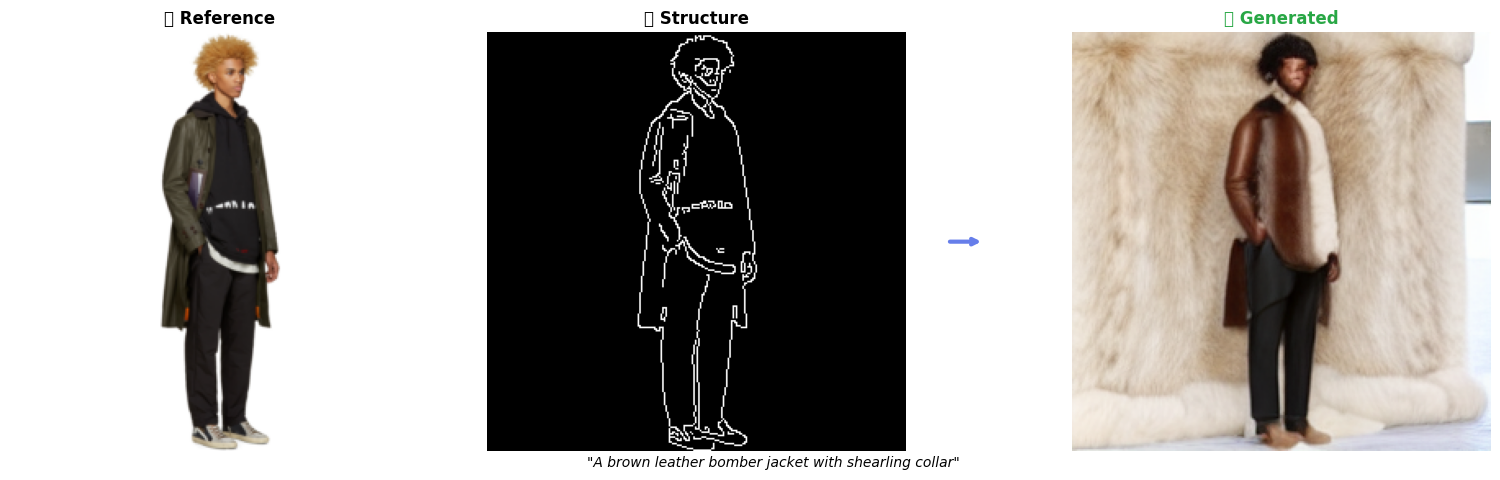

💾 Saved generated image: output_seed1788200409.png


👋 Thank you for using the Fashion Image Generator!


In [8]:
# CELL 5: Interactive Terminal-Based Generator
import random
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

print("=" * 70)
print("🎨 INTERACTIVE FASHION IMAGE GENERATOR")
print("=" * 70)
print("\n💡 Type your prompt and press Enter to generate images!")
print("   Type 'quit' or 'exit' to stop.")
print("=" * 70)

def interactive_generate():
    """Interactive terminal-based image generation"""
    
    # Check if we have sample images
    if not sample_image_paths:
        print("\n❌ No sample images found!")
        print("   Please add images to: /home/husnain/DLP/working/eval_data/gt/")
        return
    
    # Get list of sample keys
    sample_keys = list(sample_image_paths.keys())
    
    while True:
        print("\n" + "-" * 70)
        
        # Get user prompt
        prompt = input("\n✏️  Enter your fashion prompt (or 'quit' to exit): ").strip()
        
        # Check for exit
        if prompt.lower() in ['quit', 'exit', 'q']:
            print("\n👋 Thank you for using the Fashion Image Generator!")
            break
        
        # Check for empty prompt
        if not prompt:
            print("⚠️  Please enter a valid prompt!")
            continue
        
        # Ask for reference image selection
        print("\n📷 Reference Image Options:")
        print("   1. Use random sample")
        print("   2. Select specific sample (by number)")
        print("   3. Use previous image (if available)")
        
        choice = input("\nChoice (1/2/3) [default: 1]: ").strip() or "1"
        
        # Select reference image
        if choice == "2":
            print(f"\n📁 Available samples: 1 to {len(sample_keys)}")
            try:
                sample_num = int(input("Enter sample number: ").strip())
                if 1 <= sample_num <= len(sample_keys):
                    sample_key = sample_keys[sample_num - 1]
                else:
                    print(f"⚠️  Invalid number. Using random sample.")
                    sample_key = random.choice(sample_keys)
            except ValueError:
                print("⚠️  Invalid input. Using random sample.")
                sample_key = random.choice(sample_keys)
        else:
            sample_key = random.choice(sample_keys)
        
        # Load reference image
        ref_img = Image.open(sample_image_paths[sample_key]).convert('RGB')
        ref_img_resized = ref_img.resize((256, 256), Image.LANCZOS)
        
        print(f"\n📌 Using: {sample_key}")
        print(f"📝 Prompt: \"{prompt}\"")
        
        # Ask for generation settings
        print("\n⚙️  Generation Settings:")
        try:
            steps = input("   Steps (10-40) [default: 20]: ").strip()
            steps = int(steps) if steps else 20
            steps = max(10, min(40, steps))
        except ValueError:
            steps = 20
        
        try:
            guidance = input("   Guidance Scale (1.0-12.0) [default: 7.5]: ").strip()
            guidance = float(guidance) if guidance else 7.5
            guidance = max(1.0, min(12.0, guidance))
        except ValueError:
            guidance = 7.5
        
        try:
            seed = input("   Seed (-1 for random) [default: -1]: ").strip()
            seed = int(seed) if seed else -1
        except ValueError:
            seed = -1
        
        print(f"\n⏳ Generating with steps={steps}, guidance={guidance}...")
        print("   (This may take 10-30 seconds depending on your GPU)")
        
        # Generate
        try:
            edge_img, generated_img, used_seed = generate_image(
                ref_img_resized, 
                prompt, 
                steps=steps, 
                guidance=guidance, 
                seed=seed
            )
            
            # Display results
            print(f"\n✅ Generation complete! (Seed: {used_seed})")
            
            # Create beautiful visualization
            fig = plt.figure(figsize=(16, 5))
            gs = gridspec.GridSpec(1, 4, width_ratios=[1, 1, 0.1, 1.2])
            
            # Reference
            ax1 = fig.add_subplot(gs[0])
            ax1.imshow(ref_img_resized)
            ax1.set_title('📷 Reference', fontsize=12, fontweight='bold')
            ax1.axis('off')
            
            # Edge Map
            ax2 = fig.add_subplot(gs[1])
            ax2.imshow(edge_img)
            ax2.set_title('🔲 Structure', fontsize=12, fontweight='bold')
            ax2.axis('off')
            
            # Arrow
            ax_arrow = fig.add_subplot(gs[2])
            ax_arrow.annotate('', xy=(0.9, 0.5), xytext=(0.1, 0.5),
                              arrowprops=dict(arrowstyle='->', color='#667eea', lw=3))
            ax_arrow.axis('off')
            
            # Generated
            ax3 = fig.add_subplot(gs[3])
            ax3.imshow(generated_img)
            ax3.set_title('✨ Generated', fontsize=12, fontweight='bold', color='#28a745')
            ax3.axis('off')
            
            # Add prompt
            display_prompt = f'\"{prompt[:70]}...\"' if len(prompt) > 70 else f'\"{prompt}\"'
            fig.suptitle(display_prompt, fontsize=10, style='italic', y=0.02)
            
            plt.tight_layout()
            
            # Save output
            output_filename = f"generated_seed{used_seed}.png"
            plt.savefig(output_filename, dpi=150, bbox_inches='tight')
            print(f"💾 Saved: {output_filename}")
            
            plt.show()
            plt.close()
            
            # Save source image, generated image, and metadata
            save_generation_results(
                source_img=ref_img_resized,
                generated_img=generated_img,
                seed=used_seed,
                prompt=prompt,
                steps=steps,
                guidance=guidance,
                prefix="output"
            )
            
        except Exception as e:
            print(f"\n❌ Error during generation: {str(e)}")
            print("   Please try again with different settings.")
            continue
        
        # Ask if user wants to continue
        print("\n" + "=" * 70)
        continue_choice = input("Generate another image? (y/n) [default: y]: ").strip().lower()
        if continue_choice in ['n', 'no']:
            print("\n👋 Thank you for using the Fashion Image Generator!")
            break

# Run the interactive generator
print("\n🚀 Starting interactive mode...\n")
interactive_generate()

🚀 QUICK GENERATOR - Single Prompt Mode

📌 Using: Sample 0305
📝 Prompt: "A classic black leather jacket with silver zippers and fitted silhouette"
⏳ Generating (this may take 10-30 seconds)...


  0%|          | 0/20 [00:00<?, ?it/s]

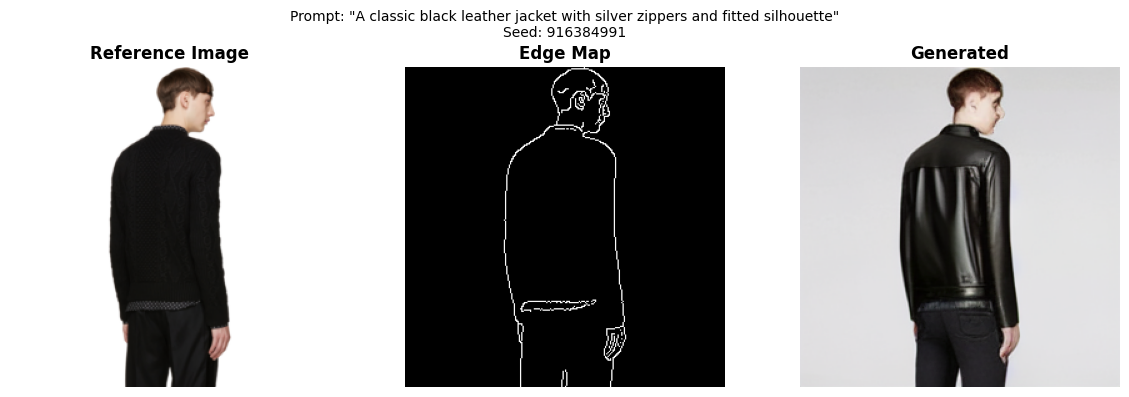

💾 Saved source image: quick_output_seed916384991_source.png
💾 Saved generated image: quick_output_seed916384991_generated.png
💾 Saved metadata: quick_output_seed916384991_metadata.json
🎲 Seed: 916384991
📦 LoRA Weights: /home/husnain/DLP/working/fashion_lora_output/pytorch_lora_weights.safetensors
🔑 LoRA Hash: aa0fce26c9a93d83

✅ Done!


In [23]:
# CELL 6: Quick Single Prompt Generator (Simplified)
import random

print("=" * 70)
print("🚀 QUICK GENERATOR - Single Prompt Mode")
print("=" * 70)

# Simple one-shot generation
prompt = input("\n✏️  Enter your fashion prompt: ").strip()

if prompt:
    # Use random sample
    sample_key = random.choice(list(sample_image_paths.keys()))
    ref_img = Image.open(sample_image_paths[sample_key]).convert('RGB')
    
    print(f"\n📌 Using: {sample_key}")
    print(f"📝 Prompt: \"{prompt}\"")
    print(f"⏳ Generating (this may take 10-30 seconds)...")
    
    # Generate with default settings
    edges, generated, seed = generate_image(ref_img, prompt, steps=20, guidance=7.5)
    
    # Display
    display_results(ref_img.resize((256, 256)), edges, generated, prompt, seed)
    
    # Save source image, generated image, and metadata
    save_generation_results(
        source_img=ref_img.resize((256, 256)),
        generated_img=generated,
        seed=seed,
        prompt=prompt,
        steps=20,
        guidance=7.5,
        prefix="quick_output"
    )
    print(f"\n✅ Done!")
else:
    print("⚠️  No prompt entered!")

In [10]:
# CELL 4: Simple Generation Interface
from IPython.display import HTML
import random

print("="*60)
print("👗 FASHION IMAGE GENERATOR - READY!")
print("="*60)
print("\n📝 Quick Start:")
print("   1. Use generate_image() function to create fashion images")
print("   2. Choose from sample images or upload your own")
print("   3. Experiment with different prompts and settings")
print("\n💡 Example Usage:")
print("   # Pick a random sample")
print("   sample_key = random.choice(list(sample_image_paths.keys()))")
print("   ref_img = Image.open(sample_image_paths[sample_key])")
print("   ")
print("   # Generate")
print("   edges, generated, seed = generate_image(")
print("       ref_img,")
print("       prompt='A sleek black leather jacket',")
print("       steps=20,")
print("       guidance=7.5")
print("   )")
print("   ")
print("   # Display results")
print("   display_results(ref_img.resize((256,256)), edges, generated, 'Prompt here', seed)")
print("\n" + "="*60)

# Example presets
EXAMPLE_PROMPTS = [
    "A classic black leather jacket with silver zippers and fitted silhouette",
    "A tailored navy blue blazer with gold buttons and sharp lapels",
    "An elegant cream silk blouse with subtle sheen",
    "A bright red silk evening dress with elegant draping",
    "Classic dark indigo straight-leg denim jeans",
    "A cozy beige cashmere sweater with ribbed texture",
]

print("\n📋 Example Prompts:")
for i, prompt in enumerate(EXAMPLE_PROMPTS, 1):
    print(f"   {i}. {prompt}")

print("\n💾 Available sample images:", len(sample_image_paths))
print("\n🚀 Ready to generate! Try the example code above.")

👗 FASHION IMAGE GENERATOR - READY!

📝 Quick Start:
   1. Use generate_image() function to create fashion images
   2. Choose from sample images or upload your own
   3. Experiment with different prompts and settings

💡 Example Usage:
   # Pick a random sample
   sample_key = random.choice(list(sample_image_paths.keys()))
   ref_img = Image.open(sample_image_paths[sample_key])
   
   # Generate
   edges, generated, seed = generate_image(
       ref_img,
       prompt='A sleek black leather jacket',
       steps=20,
       guidance=7.5
   )
   
   # Display results
   display_results(ref_img.resize((256,256)), edges, generated, 'Prompt here', seed)


📋 Example Prompts:
   1. A classic black leather jacket with silver zippers and fitted silhouette
   2. A tailored navy blue blazer with gold buttons and sharp lapels
   3. An elegant cream silk blouse with subtle sheen
   4. A bright red silk evening dress with elegant draping
   5. Classic dark indigo straight-leg denim jeans
   6. A cozy 